In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.table import Table
import seaborn as sns
from scipy.stats import poisson
#matplotlib.use('Agg')
%matplotlib inline

max value change 191.42362498822553
max value change 126.95224148478934
max value change 81.1030240895065
max value change 59.57293461377046
max value change 44.256406740847694
max value change 33.66354757431691
max value change 29.406484730189362
max value change 25.722851101968303
max value change 22.386305970352936
max value change 19.412322619464305
max value change 16.78773029464071
max value change 14.48674086123475
max value change 12.478927756039411
max value change 10.733180573778156
max value change 9.219614672880823
max value change 7.9104460792187865
max value change 6.7803411163487795
max value change 5.806494885678262
max value change 4.9685670708238945
max value change 4.2485426698470405
max value change 3.630555231738981
max value change 3.100694577777631
max value change 2.6468122880531837
max value change 2.258333022324109
max value change 1.9260764476246095
max value change 1.64209238964321
max value change 1.3995103974238532
max value change 1.192403969441159
max va

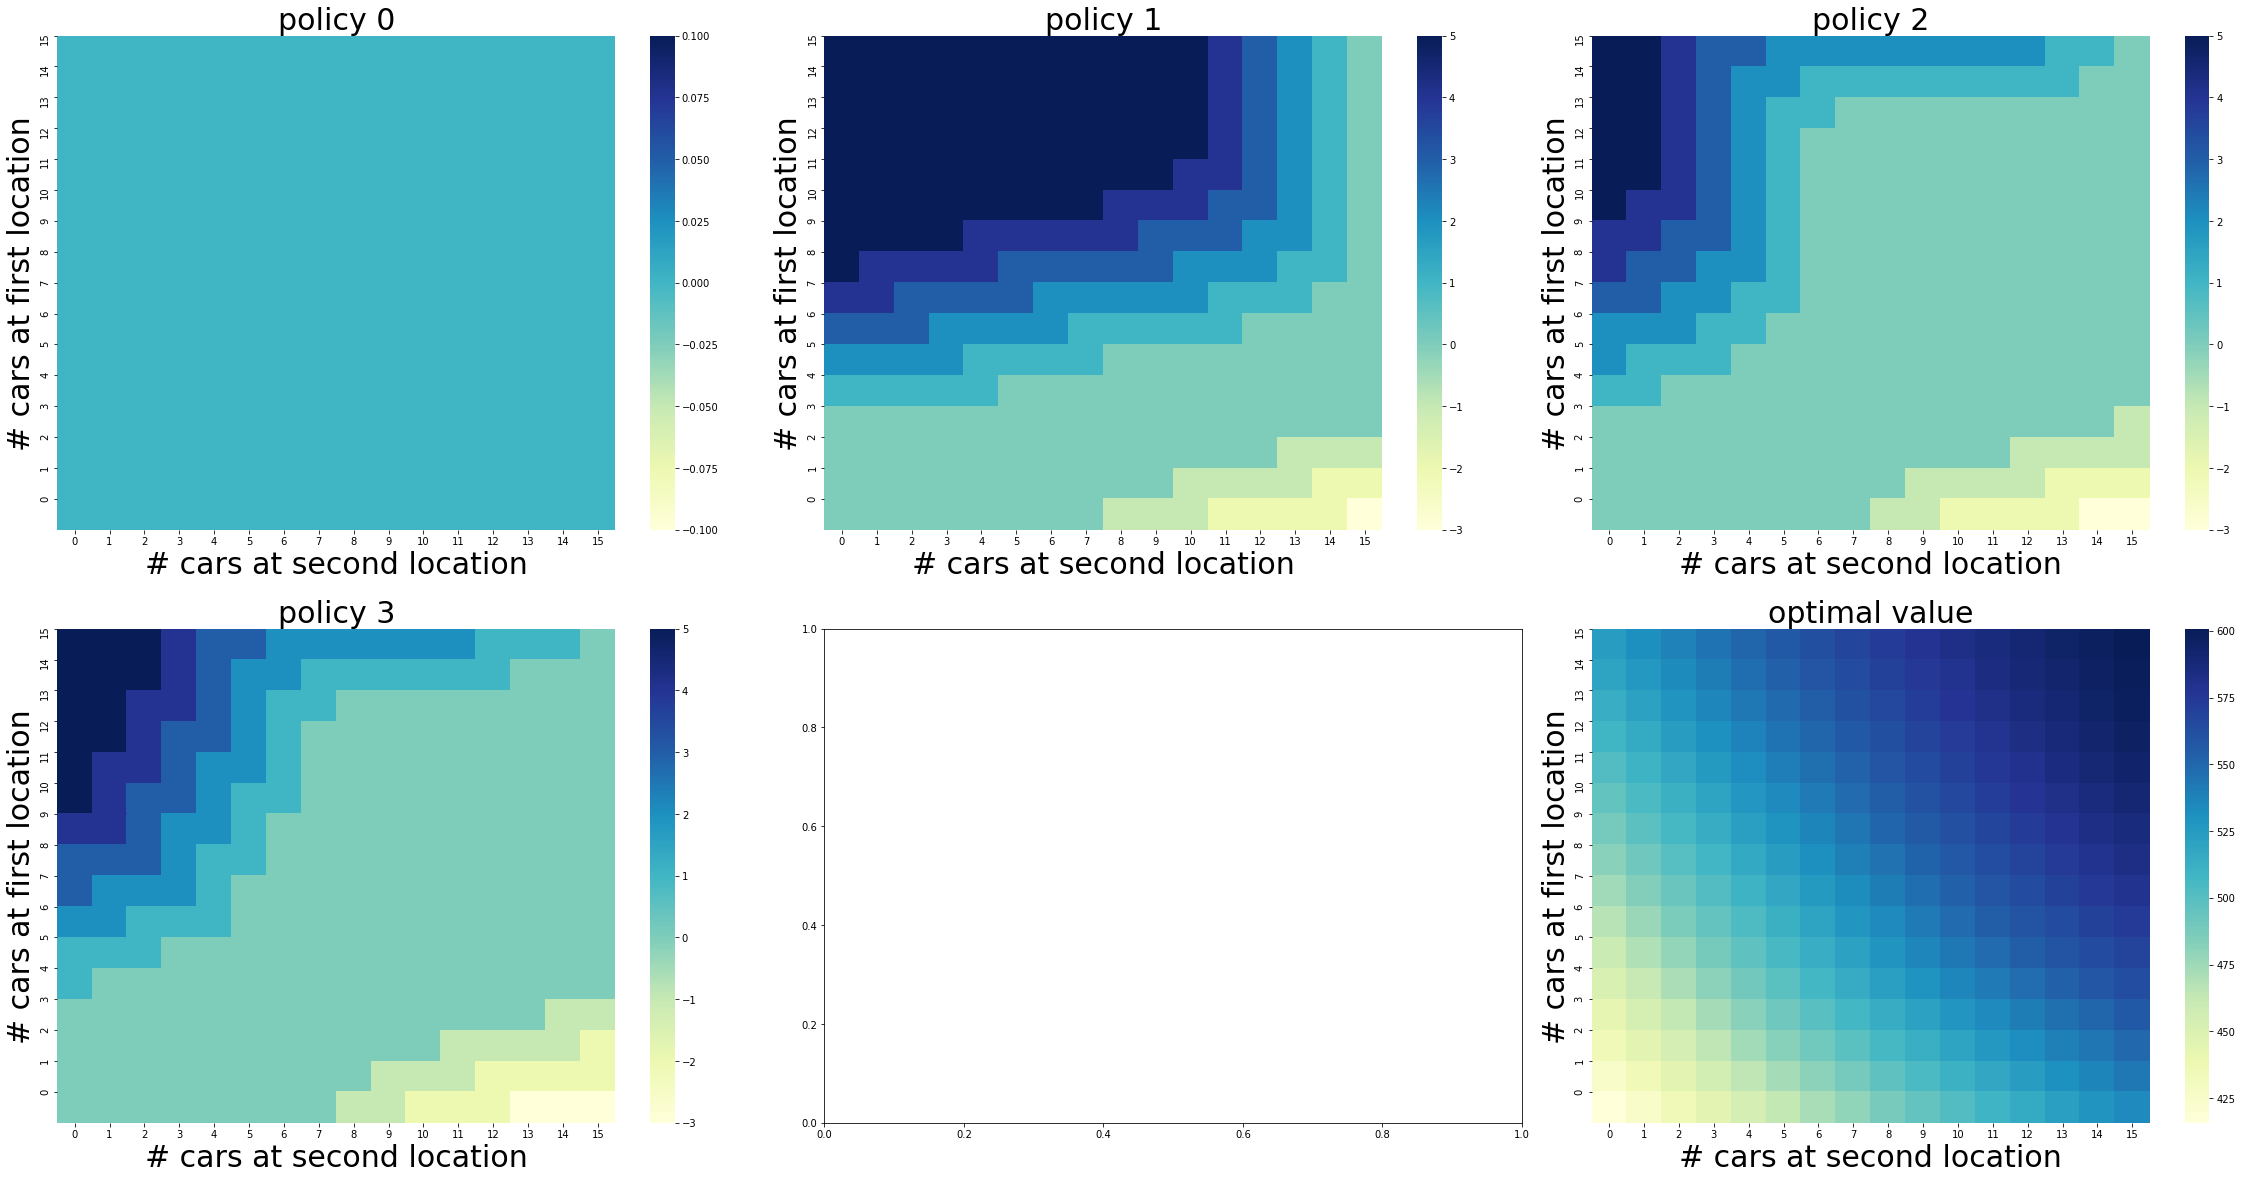

In [2]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# 2017 Aja Rangaswamy (aja004@gmail.com)                              #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

################################ code changed from 20 max cars to 15 max cars

# maximum # of cars in each location
MAX_CARS = 15

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

DISCOUNT = 0.9

# credit earned by a car
RENTAL_CREDIT = 10

# cost of moving a car
MOVE_CAR_COST = 2

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

# An up bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UPPER_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_cache = dict()


def poisson_probability(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]


def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initailize total return
    returns = 0.0

    # cost for moving cars
    returns -= MOVE_CAR_COST * abs(action)

    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)

    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual # of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns


def figure_4_2(constant_returned_cars=True):
    value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    policy = np.zeros(value.shape, dtype=np.int)

    iterations = 0
    _, axes = plt.subplots(2, 3, figsize=(40, 20))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()
    while True:
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iterations])
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('policy {}'.format(iterations), fontsize=30)

        # policy evaluation (in-place)
        while True:
            old_value = value.copy()
            for i in range(MAX_CARS + 1):
                for j in range(MAX_CARS + 1):
                    new_state_value = expected_return([i, j], policy[i, j], value, constant_returned_cars)
                    value[i, j] = new_state_value
            max_value_change = abs(old_value - value).max()
            print('max value change {}'.format(max_value_change))
            if max_value_change < 1e-4:
                break

        # policy improvement
        policy_stable = True
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                old_action = policy[i, j]
                action_returns = []
                for action in actions:
                    if (0 <= action <= i) or (-j <= action <= 0):
                        action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                    else:
                        action_returns.append(-np.inf)
                new_action = actions[np.argmax(action_returns)]
                policy[i, j] = new_action
                if policy_stable and old_action != new_action:
                    policy_stable = False
        print('policy stable {}'.format(policy_stable))

        if policy_stable:
            fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
            fig.set_ylabel('# cars at first location', fontsize=30)
            fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
            fig.set_xlabel('# cars at second location', fontsize=30)
            fig.set_title('optimal value', fontsize=30)
            break

        iterations += 1

    #plt.savefig('C:\\Users\\stanb\\Desktop\\University of Toronto\\Intelligent Agents and Reinforcement Learning\\Work\\Assignment3/images/ca_15maxcars.png')
    #plt.close()
    plt.show()

figure_4_2()

max value change 155.38956387232818
max value change 98.92669499825129
max value change 70.20139993707858
max value change 56.60768836323024
max value change 44.95211266169977
max value change 35.71054048914013
max value change 31.07839177009231
max value change 26.867480592192663
max value change 23.12399969064967
max value change 19.84933166229922
max value change 17.010596404591183
max value change 14.562851489618367
max value change 12.459090233826942
max value change 10.654640868931324
max value change 9.108924275975085
max value change 7.785956725481981
max value change 6.654267520564872
max value change 5.686560685810264
max value change 4.85928303027589
max value change 4.152177626056584
max value change 3.5478596522640373
max value change 3.0314301937156074
max value change 2.5901328183092005
max value change 2.213052466357624
max value change 1.8908537388714421
max value change 1.6155546996814678
max value change 1.3803320870920288
max value change 1.1793539821640593
max valu

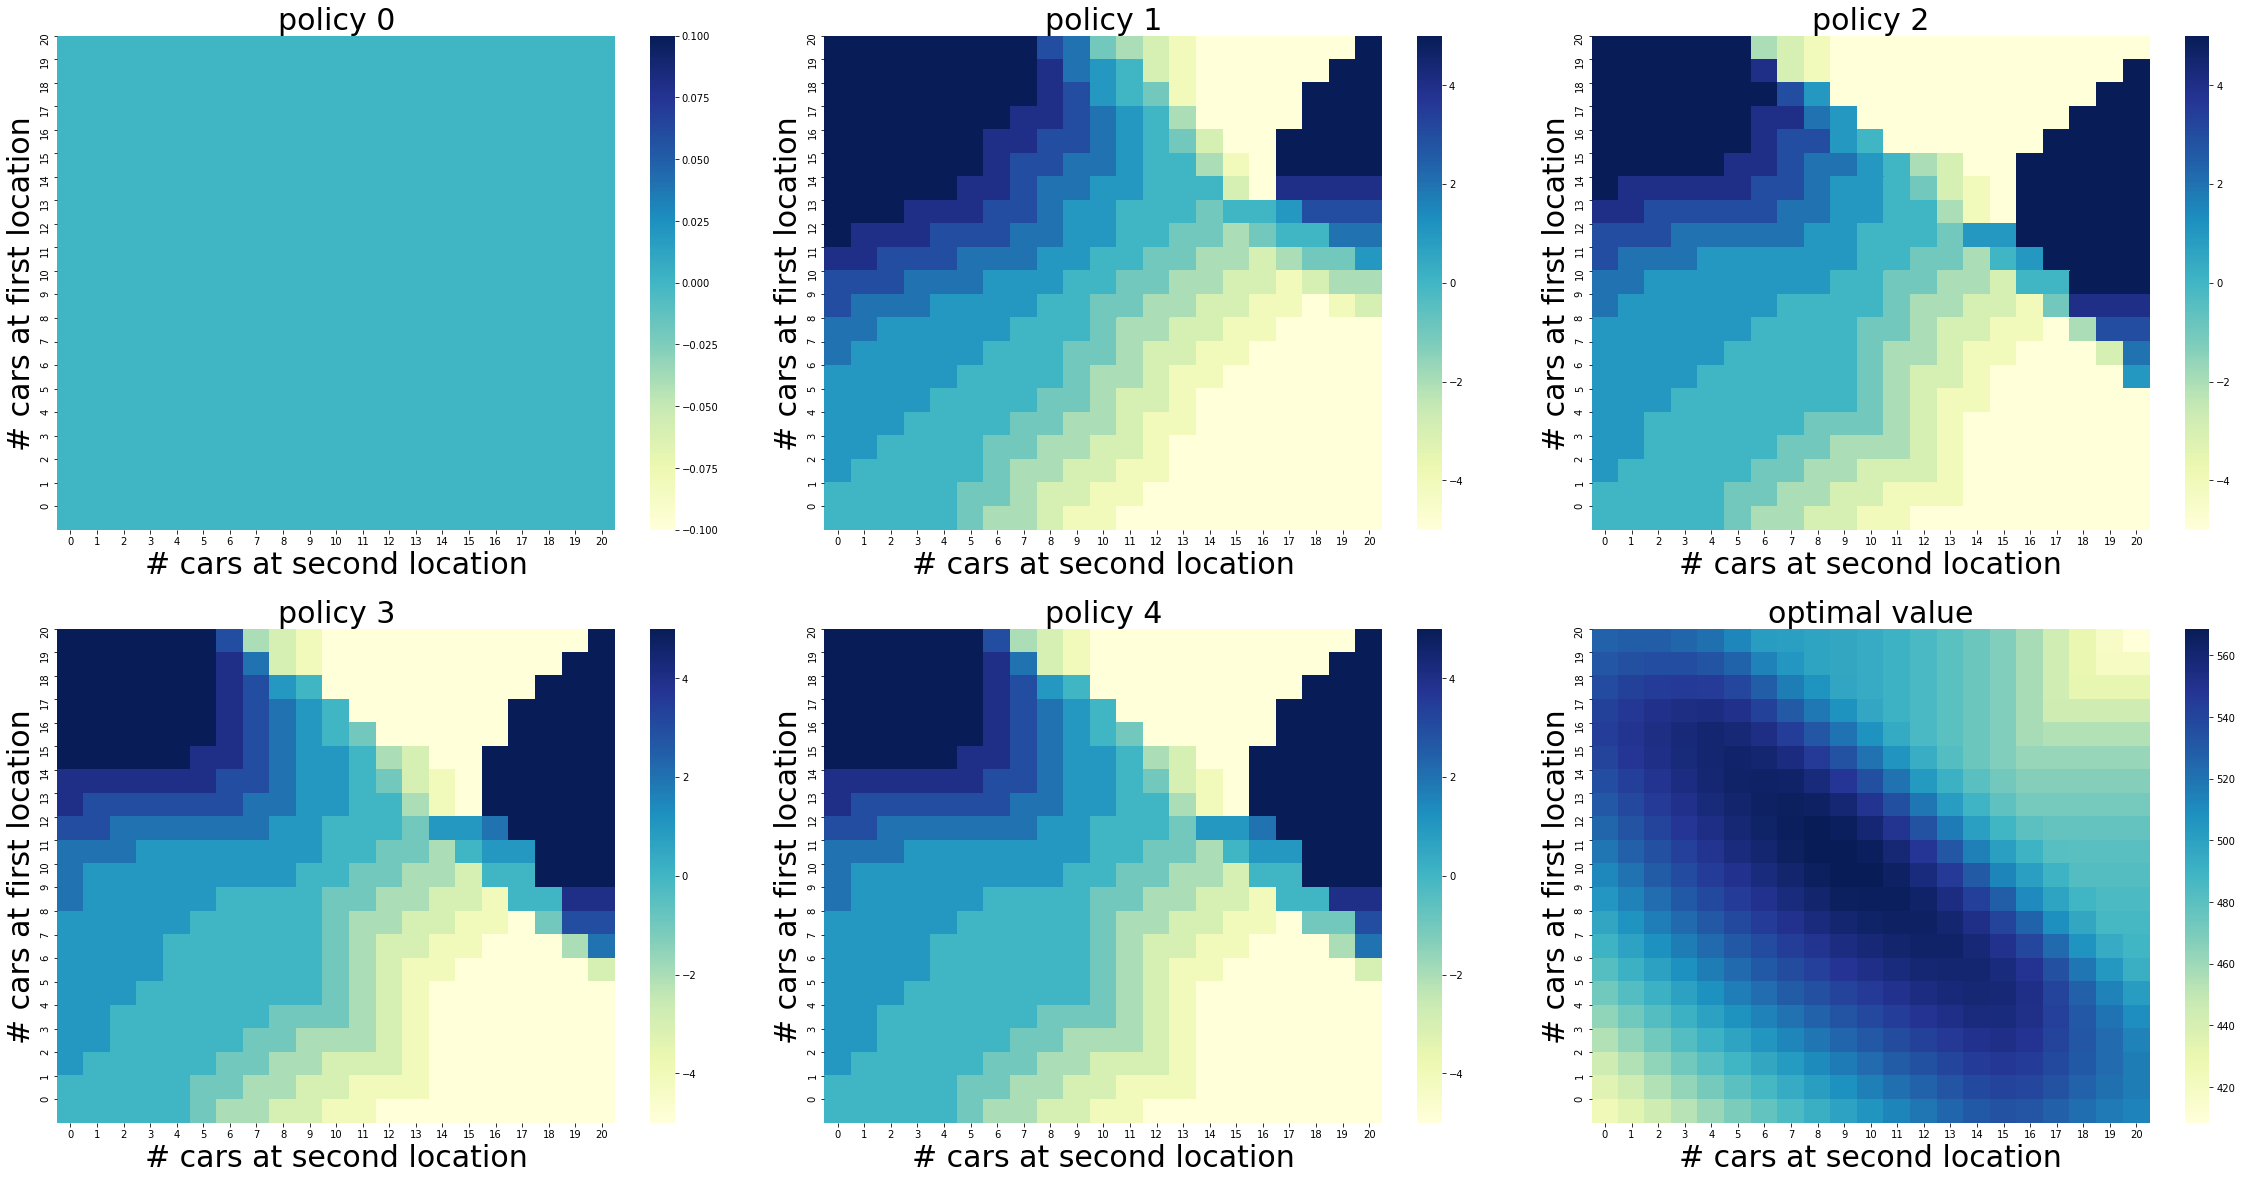

In [4]:
########################## PROBLEM #########################

#all other cars shuffled in same night 
MOVE_CAR_COST = 2

#cost of parking if more than 10 cars
COST_OF_EXTRA_PARKING = 4

# credit earned by a car
RENTAL_CREDIT = 10

# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 4

# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 3

# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3

# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2

# maximum # of cars in each location
MAX_CARS = 20

# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5

DISCOUNT = 0.9
##########################################################

# all possible actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)

# An up bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated to 0
POISSON_UPPER_BOUND = 11

# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_cache = dict()


def poisson_probability(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]


def expected_return(state, action, state_value, constant_returned_cars):
    """
    @state: [# of cars in first location, # of cars in second location]
    @action: positive if moving cars from first location to second location,
            negative if moving cars from second location to first location
    @stateValue: state value matrix
    @constant_returned_cars:  if set True, model is simplified such that
    the # of cars returned in daytime becomes constant
    rather than a random value from poisson distribution, which will reduce calculation time
    and leave the optimal policy/value state matrix almost the same
    """
    # initailize total return
    returns = 0.0

    # cost for moving cars
    if action > 0:
        returns -= MOVE_CAR_COST * abs(action - 1) #this captures the free shuttle from first to to 2nd
    else:
        returns -= MOVE_CAR_COST * abs(action)  

    # moving cars
    NUM_OF_CARS_FIRST_LOC = min(state[0] - action, MAX_CARS)
    NUM_OF_CARS_SECOND_LOC = min(state[1] + action, MAX_CARS)
    
    
    # go through all possible rental requests
    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # probability for current combination of rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)
            
            num_of_cars_first_loc = NUM_OF_CARS_FIRST_LOC
            num_of_cars_second_loc = NUM_OF_CARS_SECOND_LOC

            # valid rental requests should be less than actual # of cars
            valid_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT 
            num_of_cars_first_loc -= valid_rental_first_loc
            num_of_cars_second_loc -= valid_rental_second_loc
                         
            #PARKING COSTS
            if num_of_cars_first_loc >= 10:
                reward -= COST_OF_EXTRA_PARKING
            if num_of_cars_second_loc >= 10:
                reward -= COST_OF_EXTRA_PARKING
            

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_probability(
                            returned_cars_first_loc, RETURNS_FIRST_LOC) * poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = prob_return * prob
                        returns += prob_ * (reward + DISCOUNT *
                                            state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
        
    return returns


def figure_4_2(constant_returned_cars=True):
    value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    policy = np.zeros(value.shape, dtype=np.int)

    iterations = 0
    _, axes = plt.subplots(2, 3, figsize=(40, 20))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()
    while True:
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iterations])
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('policy {}'.format(iterations), fontsize=30)

        # policy evaluation (in-place)
        while True:
            old_value = value.copy()
            for i in range(MAX_CARS + 1):
                for j in range(MAX_CARS + 1):
                    new_state_value = expected_return([i, j], policy[i, j], value, constant_returned_cars)
                    value[i, j] = new_state_value
            max_value_change = abs(old_value - value).max()
            print('max value change {}'.format(max_value_change))
            if max_value_change < 1e-4:
                break

        # policy improvement
        policy_stable = True
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                old_action = policy[i, j]
                action_returns = []
                for action in actions:
                    if (0 <= action <= i) or (-j <= action <= 0):
                        action_returns.append(expected_return([i, j], action, value, constant_returned_cars))
                    else:
                        action_returns.append(-np.inf)
                new_action = actions[np.argmax(action_returns)]
                policy[i, j] = new_action
                if policy_stable and old_action != new_action:
                    policy_stable = False
        print('policy stable {}'.format(policy_stable))

        if policy_stable:
            fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
            fig.set_ylabel('# cars at first location', fontsize=30)
            fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
            fig.set_xlabel('# cars at second location', fontsize=30)
            fig.set_title('optimal value', fontsize=30)
            break

        iterations += 1

    plt.show()

figure_4_2()